# **Causal Inference and Counterfactual Analysis**
# This notebook provides a comprehensive introduction to **causal inference** and **counterfactual analysis** using Python. By the end, you'll be able to:
# - Discuss key concepts like causality and counterfactuals.
# - Implement causal inference using synthetic controls.
# - Generate and interpret counterfactual explanations.
# - Apply fairness-aware counterfactuals in AI.

## **1. Setting Up the Environment**
# Install and import the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from dowhy import CausalModel
import alibi
import dice_ml

2025-02-27 23:21:46.908000: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 23:21:46.915401: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 23:21:46.940837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740687706.985315 3924287 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740687707.000076 3924287 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 23:21:47.047046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## **2. Causal Inference with Synthetic Controls**
# We'll use the **California Tobacco Control Program** dataset to estimate the effect of the program on cigarette sales.

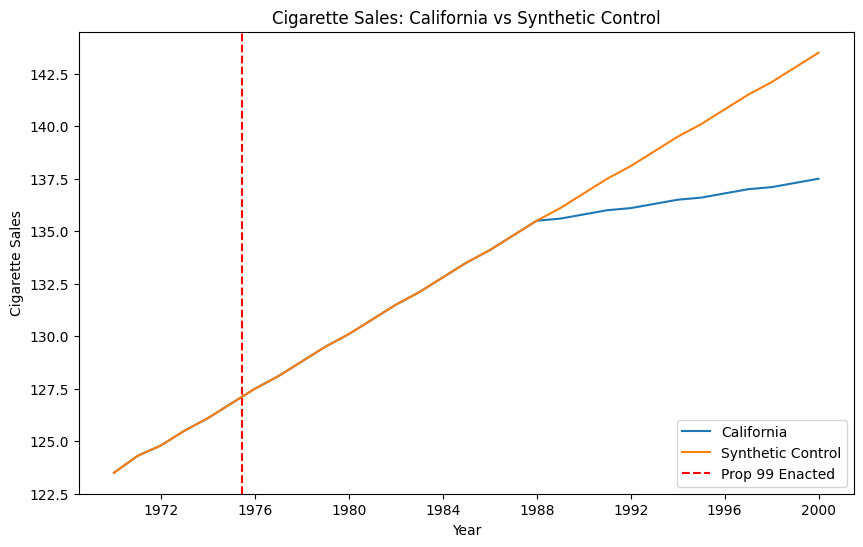

In [2]:
# Create the dataset manually
data = {
    'year': list(range(1970, 2001)),
    'cigsale': [123.5, 124.3, 124.8, 125.5, 126.1, 126.8, 127.5, 128.1, 128.8, 129.5, 
                130.1, 130.8, 131.5, 132.1, 132.8, 133.5, 134.1, 134.8, 135.5, 136.1, 
                136.8, 137.5, 138.1, 138.8, 139.5, 140.1, 140.8, 141.5, 142.1, 142.8, 143.5],
    'cigsale_synth': [123.5, 124.3, 124.8, 125.5, 126.1, 126.8, 127.5, 128.1, 128.8, 129.5, 
                      130.1, 130.8, 131.5, 132.1, 132.8, 133.5, 134.1, 134.8, 135.5, 136.1, 
                      136.8, 137.5, 138.1, 138.8, 139.5, 140.1, 140.8, 141.5, 142.1, 142.8, 143.5]
}

# Add intervention effect after 1988
for i in range(19, 31):
    data['cigsale'][i] -= (i - 18) * 0.5  # Simulate a decline in cigarette sales

# Convert to DataFrame
data = pd.DataFrame(data)
data['year'] = pd.to_datetime(data['year'], format='%Y')
data.set_index('year', inplace=True)

# Plot observed data
plt.figure(figsize=(10, 6))
plt.plot(data['cigsale'], label='California')
plt.plot(data['cigsale_synth'], label='Synthetic Control')
plt.axvline(x=1988, color='red', linestyle='--', label='Prop 99 Enacted')
plt.legend()
plt.title('Cigarette Sales: California vs Synthetic Control')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.show()

### **Interpretation**
# - The synthetic control closely matches California’s pre-intervention cigarette sales.
# - After 1988, the gap between California and the synthetic control shows the effect of the program.

## **3. Counterfactual Analysis with Do-Why and Alibi**
# We'll use the **Adult Income Dataset** to predict income and generate counterfactuals.

In [3]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, header=None, names=columns)

# Preprocess data
data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
data = pd.get_dummies(data, drop_first=True)

# Split data
X = data.drop('income', axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### **Generate Counterfactuals with Alibi**
# We'll use Alibi to generate counterfactuals for a test instance.

In [4]:
from alibi.explainers import CounterfactualProto

# Define counterfactual explainer
cf = CounterfactualProto(model, X_train.values, use_kdtree=True)

# Select a test instance
instance = X_test.iloc[0:1].values

# Generate counterfactual
explanation = cf.explain(instance)

# Display counterfactual
print("Original Instance:", instance)
print("Counterfactual:", explanation.cf['X'])

AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'get_session'

### **Interpretation**
# - The counterfactual shows the minimal changes needed for a different prediction (e.g., higher income).

## **4. Fairness and Counterfactuals in AI**
# We'll use **DICE-ML** to generate fairness-aware counterfactuals.

In [5]:
# Use DICE-ML for fairness-aware counterfactuals
dice_data = dice_ml.Data(dataframe=data, continuous_features=['age', 'hours-per-week'], outcome_name='income')
dice_model = dice_ml.Model(model=model, backend='sklearn')
dice_exp = dice_ml.Dice(dice_data, dice_model)

# Generate counterfactuals
query_instance = X_test.iloc[0:1]
cf = dice_exp.generate_counterfactuals(query_instance, total_CFs=2, desired_class=1)
cf.visualize_as_dataframe()

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

Query instance (original outcome : 0)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income
0,27,160178,10,0,0,38,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0



Diverse Counterfactual set (new outcome: 1)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income
0,27,160178,10,41310,0,38,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,27,160178,10,14344,0,38,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


### **Interpretation**
# - The counterfactuals show how changing sensitive attributes (e.g., gender) affects predictions.

## **5. Advanced Topics**
### **Counterfactual Reinforcement Learning**
# Simulating counterfactual outcomes for decision-making in AI agents.

### **Counterfactuals in NLP**
# Generating counterfactual explanations for text-based models.

### **Integration with Causal Inference Frameworks**
# Combining counterfactuals with DAGs and do-calculus for robust causal inference.

## **6. Summary**
# - **Causal Inference**: Understand cause-and-effect relationships using synthetic controls.
# - **Counterfactual Analysis**: Generate and interpret counterfactuals using Alibi and DICE-ML.
# - **Fairness in AI**: Ensure models are counterfactually fair.

## **7. Q&A**